In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
pd.options.display.float_format = '{:.2f}'.format
plt.rcParams["axes.labelsize"] = 13 #set the axis label sizes for the whole notebooks

#### Import the data

In [2]:
people = pd.read_csv('/Users/brendanferris/Desktop/scripts/ckm_challenge/data/people.csv')
simulation = pd.read_csv('/Users/brendanferris/Desktop/scripts/ckm_challenge/data/simulation.csv')

In [3]:
simulation

,action,direction,floor,subject,system,time,weight,date,date_daily
0,call,up,0,system,elevator control,2019-01-01 07:50:53.906554,nan,2019-01-01 07:00:00.000000,2019-01-01 00:00:00.000000
1,door open,NaN,0,1,elevator control,2019-01-01 07:50:53.906554,0.00,2019-01-01 07:00:00.000000,2019-01-01 00:00:00.000000
2,door open,NaN,2,1,elevator control,2019-01-01 07:51:19.006554,191.49,2019-01-01 07:00:00.000000,2019-01-01 00:00:00.000000
3,call,up,0,system,elevator control,2019-01-01 07:54:40.829759,nan,2019-01-01 07:00:00.000000,2019-01-01 00:00:00.000000
4,door open,NaN,0,2,elevator control,2019-01-01 07:54:40.829759,0.00,2019-01-01 07:00:00.000000,2019-01-01 00:00:00.000000
...,...,...,...,...,...,...,...,...,...
166936,door open,NaN,16,0,elevator control,2019-05-29 22:19:57.757071,0.00,2019-05-29 22:00:00.000000,2019-05-29 00:00:00.000000
166937,door open,NaN,0,0,elevator control,2019-05-29 22:21:18.857071,103.10,2019-05-29 22:00:00.000000,2019-05-29 00:00:00.000000
166938,call,down,2,system,elevator control,2019-05-29 22:27:20.316376,nan,2019-05-29 22:00:00.000000,2019-05-29 00:00:00.000000
166939,door open,NaN,2,3,elevator control,2019-05-29 22:27:28.316376,0.00,2019-05-29 22:00:00.000000,2019-05-29 00:00:00.000000


The `time` columns in both datasets are strings and need to be converted to datetimes for analysis.

In [4]:
print(simulation.time.dtype, '--> string')
people.time.dtype == simulation.time.dtype

object --> string


True

In [5]:
simulation['time'] = pd.to_datetime(simulation['time'], infer_datetime_format=True)
people['time'] = pd.to_datetime(people['time'], infer_datetime_format=True)

We can drop the `date` and `date_daily` columns because they don't seem to provide any value.

In [6]:
simulation.drop(['date','date_daily', 'weight'], axis=1, inplace=True)

## Initial Insights

In [7]:
unique_occupants = len(people.subject.unique())
total_occupants = people.guest.count()
print("There were %s different people occupying the building over the course of the 3 months, and a grand total of %s people in and out of the building." % (unique_occupants, total_occupants))

There were 1688 different people occupying the building over the course of the 3 months, and a grand total of 28957 people in and out of the building.


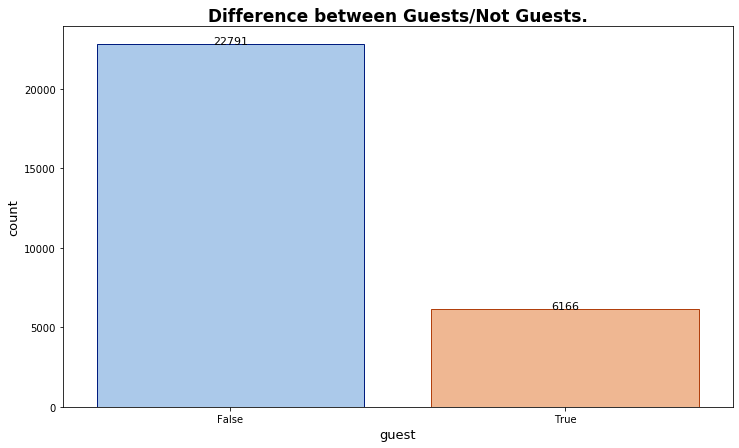

In [8]:
cntplt, ax = plt.subplots(figsize = (12,7))
ax = sns.countplot(people.guest, edgecolor=sns.color_palette("dark", 3), palette='pastel');
ax.set_title('Difference between Guests/Not Guests.',fontsize = 17, fontweight='bold' )
for rect in ax.patches:
    ax.text(rect.get_x() + rect.get_width()  / 2,rect.get_height(),rect.get_height(),horizontalalignment='center', fontsize = 11)
plt.savefig('guest_category.png')

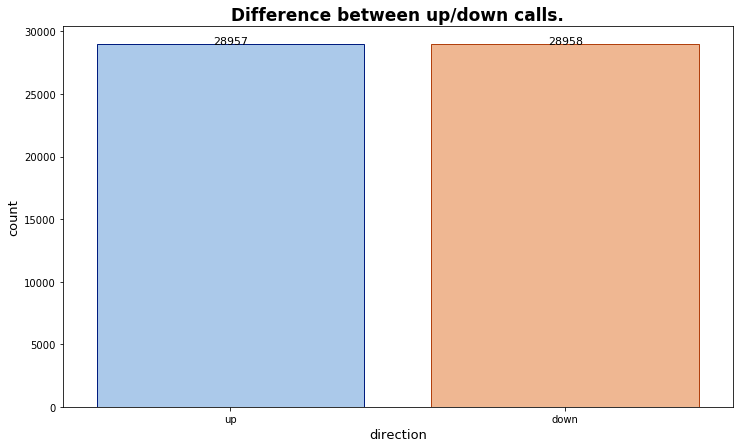

In [9]:
cntplt2, ax2 = plt.subplots(figsize = (12,7))
ax2 = sns.countplot(simulation.direction, edgecolor=sns.color_palette("dark", 3), palette='pastel');
ax2.set_title('Difference between up/down calls.',fontsize = 17, fontweight='bold' )
for rect in ax2.patches:
    ax2.text(rect.get_x() + rect.get_width()  / 2,rect.get_height(),rect.get_height(),horizontalalignment='center', fontsize = 11)
plt.savefig('up_down_calls.png')

The elevators have a 50/50 split between up and down calls, suggesting that the building is used for professional use only. This was also hinted at in the problem description.

## Deeper Analysis

I wanted to figure out how long it took for people in the lobby to obtain an elevator. In order to do this, I needed to make one assumption about the path a person takes to the elevator. I assume that after swiping into the building security system, a persons next action is to click the call button. 

*Why did I make the assumption?*

A relative of mine works in 30 Rockefeller Center, and I have spent a good amount of time in the building. The process for entering the building is similar to the one described in the challenge description. People either have a badge, or have to get one from security (guests). They then have to swipe the badge at the entrance of one of the elevator corridors -- providing access to the elevators. There is nothing else someone can do other than call the elevator after swiping their badge. You can view that corridor [here](https://external-content.duckduckgo.com/iu/?u=https%3A%2F%2Fmedia-cdn.tripadvisor.com%2Fmedia%2Fphoto-s%2F03%2Ffc%2F03%2F1b%2Ftop-of-the-rock-observation.jpg&f=1&nofb=1), the pillars sticking out into the hallway are the turnstyles where the badges are swiped.  

In [10]:
# I need to duplicate this column so I can return it after the merge.
people['swipe_time'] = people['time']

calls_to_lobby = simulation.loc[(simulation['action'] == 'call') & (simulation['floor'] == 0)]
# I had to look up how to achieve this in the pandas docs.
people_entering = pd.merge_asof(calls_to_lobby[['action','system', 'direction','floor', 'time']].sort_values('time'), people[['time', 'guest', 'swipe_time', 'subject']].sort_values('time'), on='time', direction='backward', allow_exact_matches=False)
people_entering.head(5)

,action,system,direction,floor,time,guest,swipe_time,subject
0,call,elevator control,up,0,2019-01-01 07:50:53.906554,True,2019-01-01 07:50:22.678631,Charlotta SCHNITTGER
1,call,elevator control,up,0,2019-01-01 07:54:40.829759,True,2019-01-01 07:54:09.941757,Vassie GALARSA
2,call,elevator control,up,0,2019-01-01 08:01:37.689910,True,2019-01-01 08:00:54.406641,Wenzel ERBSTOESSER
3,call,elevator control,up,0,2019-01-01 08:10:29.154320,True,2019-01-01 08:10:02.745435,Rayan SHATTUCK
4,call,elevator control,up,0,2019-01-01 08:15:34.082043,True,2019-01-01 08:14:58.313058,Heath HILLMANN


Now I can subtract the time people hit the call button from the time they swiped in, and see how long they all had to wait for an elevator to arrive in the lobby.

In [11]:
people_entering['time_to_call_button'] = people_entering['time'] - people_entering['swipe_time']

In [12]:
people_entering.time_to_call_button[0:10]

0   00:00:31.227923
1   00:00:30.888002
2   00:00:43.283269
3   00:00:26.408885
4   00:00:35.768985
5   00:00:40.175388
6   00:00:05.927107
7   00:00:20.535374
8   00:00:16.546781
9   00:00:31.574212
Name: time_to_call_button, dtype: timedelta64[ns]

In [13]:
average_lobby_wait = people_entering.time_to_call_button.mean()
print("On average, people waited %s seconds for an elevator to arrive in the lobby." %average_lobby_wait.seconds)

longest_lobby_wait = people_entering.time_to_call_button.max()
print("The longest someone had to wait was %s seconds." %longest_lobby_wait.seconds)

On average, people waited 28 seconds for an elevator to arrive in the lobby.
The longest someone had to wait was 59 seconds.


Now, lets answer the three main questions:

- The overall wait time.
- Times during the day that elevator wait times are longer.
- Floors where elevator wait times are longer.

In order to answer these, we can make a simple search to look for all the elevator calls, then search for the next time an elevator arrived on the floor where the initial call was made. 

In [14]:
simulation['wait_time'] = np.nan  #how long did the user wait
simulation['arriving_elevator'] = '' #which elevator arrived for them
simulation['arriving_from_floor'] = '' #the floor the arriving elevator was coming from

In [15]:
%%time

for row in simulation.itertuples():    
    if row.subject == 'system':
        forward_search = simulation.iloc[row.Index: row.Index + 200]
        for search_row in forward_search.itertuples():
            if row.floor == search_row.floor and search_row.action == 'door open':
                res = search_row.time - row.time
                simulation.at[row.Index, 'wait_time'] = res.seconds
                simulation.at[row.Index, 'arriving_elevator'] = search_row.subject
                break
            else:
                continue
        backward_search = simulation.iloc[row.Index::-1]
        for back_row in backward_search.itertuples():
            if back_row.subject == search_row.subject and back_row.action == 'door open':
                simulation.at[row.Index, 'arriving_from_floor'] = back_row.floor
                break
            else: #edge case for entries that are in the beginning of the day
                simulation.at[row.Index, 'arriving_from_floor'] = row.floor
                continue

CPU times: user 8min 46s, sys: 45.1 s, total: 9min 31s
Wall time: 9min 36s


In [16]:
simulation.wait_time.fillna(0, inplace=True)

simulation.wait_time = simulation.wait_time.astype(int)

We can also add a column for the `total_floors_traveled` to get to the person who hit the call button.

In [17]:
def floors_traveled(x):
    if x.subject == 'system':
        res = abs(x.floor - x.arriving_from_floor)
        return res
    else:
        return 0 #we will only perform analysis on the button call rows, so these 0's won't cause any issues.

floor_diffs = simulation.apply(floors_traveled, axis=1)

simulation['total_floors_traveled'] = floor_diffs

Let's set the `time` column as a DatetimeIndex.

In [18]:
simulation = simulation.set_index('time')

In [19]:
print("Dataframe index was changed to: %s" %simulation.index.dtype)

Dataframe index was changed to: datetime64[ns]


Now if we subset the dataset to only the elevator `call` actions, we will have a lot of meaningful information to answer the provided questions.

In [20]:
wait_times = simulation.loc[simulation['action'] == 'call']
wait_times.head(5)

,action,direction,floor,subject,system,wait_time,arriving_elevator,arriving_from_floor,total_floors_traveled
time,,,,,,,,,
2019-01-01 07:50:53.906554,call,up,0,system,elevator control,0,1,0,0
2019-01-01 07:54:40.829759,call,up,0,system,elevator control,0,2,0,0
2019-01-01 08:01:37.689910,call,up,0,system,elevator control,0,0,0,0
2019-01-01 08:10:29.154320,call,up,0,system,elevator control,0,3,0,0
2019-01-01 08:15:34.082043,call,up,0,system,elevator control,8,2,2,2


### Overall wait time?

In [21]:
overall_average = wait_times.wait_time.mean()

print("The overall average wait time is: %s seconds" %np.round(overall_average, 2))

The overall average wait time is: 25.69 seconds


### Times during the day in which elevator wait times are longer?

In [22]:
waits_series = wait_times.wait_time

hourly_waits_plt = waits_series.groupby(waits_series.index.hour).mean()

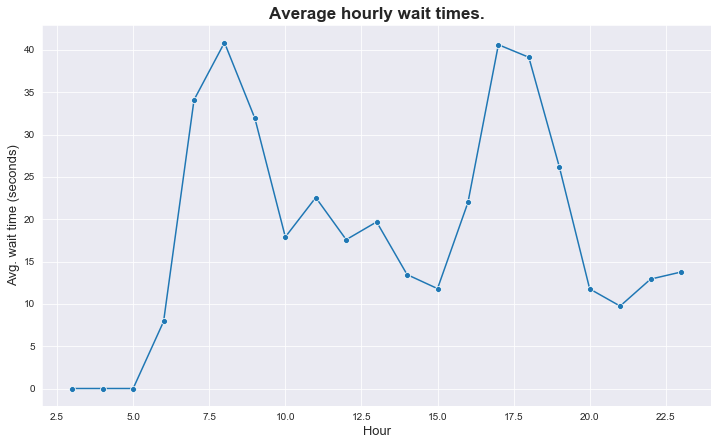

In [23]:
sns.set_style("darkgrid")

waitplt, ax = plt.subplots(figsize = (12,7))
ax = sns.lineplot(data=hourly_waits_plt, marker='o')
ax.set_title('Average hourly wait times.',fontsize = 17, fontweight='bold' )
ax.set_xlabel('Hour')
ax.set_ylabel('Avg. wait time (seconds)');
plt.savefig('average_hourly_waits.png')

As we can see from the above line graph, wait times spike during the beginning (shortly after 7:30 AM) and end (between 4:00 PM - 7/8:00 PM) of the day.

### On what floors are the elevator wait times longer?

In [24]:
first_quartile = wait_times.groupby('floor').wait_time.quantile(.25)
second_quartile = wait_times.groupby('floor').wait_time.quantile(.50)
third_quartile = wait_times.groupby('floor').wait_time.quantile(.75)

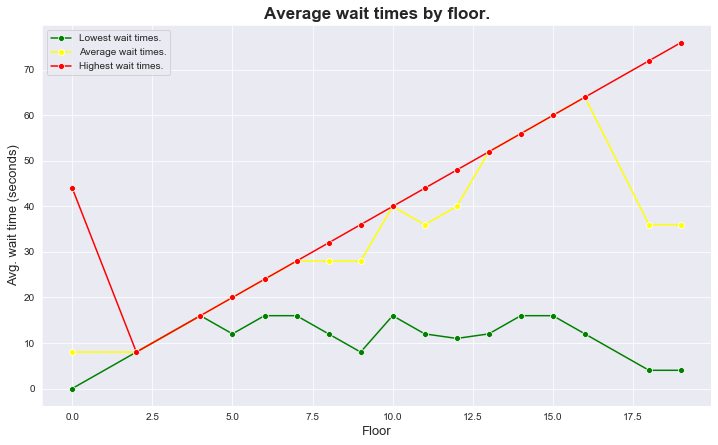

In [25]:
sns.set_style("darkgrid")

waitplt, ax = plt.subplots(figsize = (12,7))
ax = sns.lineplot(data=first_quartile, marker='o', color='green', label='Lowest wait times.')
ax = sns.lineplot(data=second_quartile, marker='o', color='yellow', label='Average wait times.')
ax = sns.lineplot(data=third_quartile, marker='o', color='red', label='Highest wait times.')
ax.legend()
ax.set_title('Average wait times by floor.',fontsize = 17, fontweight='bold' )
ax.set_xlabel('Floor')
ax.set_ylabel('Avg. wait time (seconds)');
plt.savefig('wait_times_by_floor.png')

In [26]:
wait_times.floor.unique()

array([ 0,  2,  9, 10, 19, 16, 11,  5,  4, 12, 18,  8,  7, 14, 15,  6, 13])

It can be safe to assume that the red line above are those which are primarily complaining about wait times. The relationship between average wait times and `floor` is (mostly) linear, meaning that the higher in the building you are, the longer you will wait for an elevator.

In the bar graph below we can see that those who waited over a minute for an elevator did so primarily because the arriving elevator was traveling from the lobby.

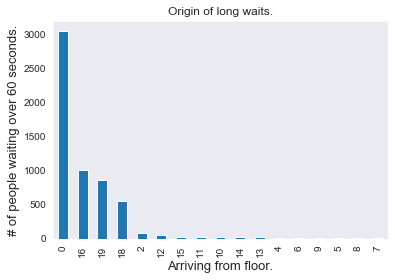

In [62]:
v = simulation.loc[simulation['wait_time'] > 60].arriving_from_floor.value_counts()

plt.figure()

ax = v.plot(kind='bar')
ax.set_ylabel('# of people waiting over 60 seconds.')
ax.set_xlabel('Arriving from floor.')
ax.set_title('Origin of long waits.')
plt.savefig('defaults_to_zero.png')

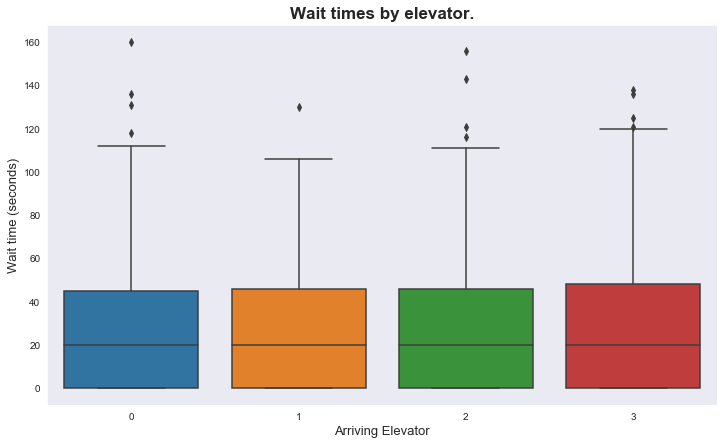

In [27]:
sns.set_style("dark")
elevplt, ax = plt.subplots(figsize = (12,7))
ax = sns.boxplot(data=wait_times, x='arriving_elevator', y='wait_time')
ax.set_title('Wait times by elevator.',fontsize = 17, fontweight='bold' )
ax.set_xlabel('Arriving Elevator')
ax.set_ylabel('Wait time (seconds)');
plt.savefig('wait_times_by_elevator.png')

Wait times for elevator 1 seem to be consistent; however, wait times for elevators 0, 2 and 3 have a lot of outliers.

# Recommendations

From this analysis, we've identified two main pain points which are leading to longer elevator wait times: 

*1) A surge of entrants in the morning causes a spike in elevator wait times between 7:30 AM and 10:00 AM.*

*2) Employees exit mainly between 3:00 PM and 8:00 PM, and within this window of time, as time passes, wait times for the elevators spike.*

In order to ease the time burden for those on the lobby and upper floors we would suggest the following:

- As time goes on, people in the lobby begin to spend more time waiting for their elevator to arrive. If a `swipe` tiggered a subset (or one) of the elevators to travel towards the lobby that would alleviate some of the time burden from the lobby. 

- All elevator's default to the lobby (Floor 0), but the people that wait the longest are on the top floors. The building manager should allocate at least one elevator to default to the top floor (Floor 19), or some middle floor other than the lobby in order to reduce wait times at peak hours. In the dataframe below you can see that elevator 1 is first to pick up someone and take them to the second floor, in the last cell elevator 1 opens at ground level (Floor 0) again with no wait time, this pattern repeats at the beginning of each day over the course of the three months.

In [28]:
simulation.head(20)

,action,direction,floor,subject,system,wait_time,arriving_elevator,arriving_from_floor,total_floors_traveled
time,,,,,,,,,
2019-01-01 07:50:53.906554,call,up,0,system,elevator control,0,1,0,0
2019-01-01 07:50:53.906554,door open,NaN,0,1,elevator control,0,,,0
2019-01-01 07:51:19.006554,door open,NaN,2,1,elevator control,0,,,0
2019-01-01 07:54:40.829759,call,up,0,system,elevator control,0,2,0,0
2019-01-01 07:54:40.829759,door open,NaN,0,2,elevator control,0,,,0
2019-01-01 07:55:05.929759,door open,NaN,2,2,elevator control,0,,,0
2019-01-01 08:01:37.689910,call,up,0,system,elevator control,0,0,0,0
2019-01-01 08:01:37.689910,door open,NaN,0,0,elevator control,0,,,0
2019-01-01 08:02:30.789910,door open,NaN,9,0,elevator control,0,,,0


### Post Mortem.

Over the course of this excercise, I made a point to only devote the allotted time (6-8 hours) to the task. If I would have had more time, here are some of the things I would have done:


- Control for all elevator users that hit the call button multiple times. 

- In the first pass, I only used information that I saw from the first entrants into the building to determine the default "home" location of the elevators (Floor 0). If I had more time I would confirm this programatically.

- The search algorithm used to glean most of the insights used in this analysis was sufficient for a first pass exploratory analysis, but not for a production environment. For example, if we had real-time elevator data it would be too slow to be useful. If I had more time, I would have tried to come up with a vectorized/alternate solution to the problem.

- Weight was a tricky and tempting feature to consider. In the end, I decided that it would be a dead end as I assumed that the elevators were operating at their intended (which we don't know, but I assume they were designed for and are legal in NYC) capacity. It would be interesting to explore the relationship between weight and `wait_time` but that treads into muddy [legal waters](http://www.nyc.gov/html/dob/downloads/bldgs_code/bc27s9.pdf) which I would need a second opinion on, especially because we would be giving written advice to the client.

- I focused on answering the provided questions in the provided timeframe. If I had more time I would have tried to explore other relationships in the data and use different visualizations to present that information.

In [29]:
wait_dir = simulation.loc[simulation['wait_time'] > 60].direction.value_counts()

In [30]:
r = wait_dir.down / (wait_dir.up + wait_dir.down) * 100
print('%r percent of users who waited over a minute were traveling downward.' %r)

59.527121001390825 percent of users who waited over a minute were traveling downward.


In [31]:
wait_dir

down    3424
up      2328
Name: direction, dtype: int64

In [32]:
simulation.loc[simulation['wait_time'] > 60].arriving_elevator.value_counts()

0    1473
2    1470
3    1443
1    1366
Name: arriving_elevator, dtype: int64

In [33]:
simulation.loc[simulation['wait_time'] > 60].index.hour.value_counts()

17    1211
8     1141
9      642
18     622
11     547
12     469
16     350
13     235
7      182
19     103
10      96
14      77
15      62
20      12
21       1
22       1
6        1
Name: time, dtype: int64